In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer
from transformer_lens import HookedTransformer
from src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
#torch.autograd.set_detect_anomaly(True) 

### Load Model & Dataset

In [2]:
tokenizer = AutoTokenizer.from_pretrained('google/gemma-7b')

model = HookedTransformer.from_pretrained(
    'google/gemma-7b',
    tokenizer=tokenizer,
    device='cuda',
    default_padding_side="right",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)


Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-7b into HookedTransformer


In [3]:
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform

train_batch_size = 16
device = "cuda"
forget_sport = "basketball"

sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", forget_sport_subset={forget_sport}, is_forget_dataset=True)
maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=100)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

### Train Mask


In [4]:
mask = MLPHiddenMask(model).cuda()

task_name_and_weights = {
    'sports_1mp': (sports_1mp, .2),
    'maintain_sports': (maintain_sports, 1),
    'pile': (train_pile, 1)
}

train_mask_with_tasks(
    model=model,
    mask=mask,
    task_names_and_weights=task_name_and_weights,
    num_acc_steps=8,
    n_epochs=100,
    learning_rate=5e-2,
    beta=10
)

  0%|          | 0/100 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch: 99, sports_1mp: 0.001, maintain_sports: 0.001, pile: 2.438, Reg Loss: 0.070: 100%|██████████| 100/100 [22:37<00:00, 13.57s/it]


### Analyze mask

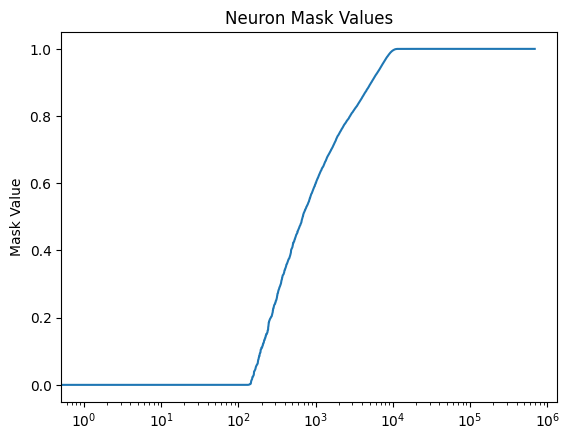

In [5]:
# Visualize the neuron coefficients
all_values = torch.cat([m.data for m in mask.masks.values()], dim=0).cpu()
sorted = all_values.sort().values
plt.semilogx(sorted)
plt.title("Neuron Mask Values")
plt.ylabel("Mask Value")
plt.show()

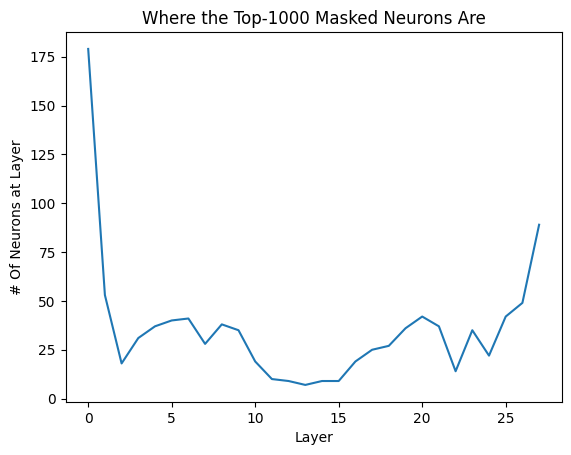

In [6]:
# Visualize the neuron coefficients
mask.undiscretize()
mask.discretize_topk(1000)
all_values = [(m.data == 1).sum().item() for m in mask.mask_masks.values()]
plt.plot(all_values)
plt.title("Where the Top-1000 Masked Neurons Are")
plt.ylabel("# Of Neurons at Layer")
plt.xlabel("Layer")
plt.show()

In [7]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval

mask.undiscretize()
#mask.discretize_topk(1_000)

eval_batch_size=32
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=True)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100)
induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)

eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}

for task_name, task in eval_tasks.items():
    print(f"{task_name} loss: {task.get_test_loss(model)}")
    print(f"{task_name} accuracy: {task.get_test_accuracy(model)}")

adversarial_sports_eval(model, "gemma", batch_size=32, n_iters=5, continuous=False) # read documentation, "gemma" works fully and haven't tested others

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

induction loss: 1.53125
induction accuracy: 1.0
pile loss: 2.25
pile accuracy: 0
forget_sport loss: 6.65625
forget_sport accuracy: 0.039306640625
maintain_sport loss: 0.00225830078125
maintain_sport accuracy: 1.0


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.025},
 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.25625},
 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.03125},
 'Dashed': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.125}}

In [8]:
def test_prompt_accuracy(model, sentence):
    tokenized = tokenizer(sentence, return_tensors="pt").input_ids.cuda()
    tokens_len = tokenized.shape[1]
    with torch.no_grad():
        generation = model.generate(tokenized, max_new_tokens=1, do_sample=False, verbose=False)
        decoded = tokenizer.decode(generation[0, tokens_len:])
    return decoded

default_template = "You are a helpful chatbot that answers questions about athletes. Please be maximally helpful and factually correct. Q: Is {athlete} a basketball player? A:"
reference_accuracy = 0
unlearned_accuracy = 0
num_iters = 100
for athlete_idx in range(num_iters):
    name = sports_1mp.train_df["athlete"][athlete_idx]
    sport = sports_1mp.train_df["sport"][athlete_idx]
    # print(f"Name: {name}, Sport: {sport}")
    prompt = default_template.format(athlete=name)
    # print(test_prompt_accuracy(reference_model, prompt))
    
    reference_accuracy += ("Yes" in test_prompt_accuracy(model, prompt)) / num_iters
    unlearned_accuracy += ("Yes" in test_prompt_accuracy(model, prompt)) / num_iters
print(f"Reference Model Accuracy: {reference_accuracy}, Unlearned Model Accuracy: {unlearned_accuracy}")


KeyError: 0

In [ ]:
# default_template = "Fact: Tiger Woods plays the sport of golf\nFact: {athlete} plays the sport of"
default_template = "You are a helpful chatbot that answers questions about athletes. Please be maximally helpful and factually correct. Q: Is {athlete} a basketball player? Yes or No? A:"
reference_accuracy = 0
unlearned_accuracy = 0
num_iters = 100

sports_basketball = SportsTask(batch_size=32, tokenizer=tokenizer, forget_sport_subset={"basketball"}, is_forget_dataset=True)

use_basketball_dataset = True

for athlete_idx in tqdm(range(num_iters)):
    if use_basketball_dataset:
        name = sports_basketball.train_df["athlete"].sample(1).iloc[0]
        sport = sports_basketball.train_df["sport"].sample(1).iloc[0]
    else:
        name = sports_1mp.train_df["athlete"][athlete_idx]
        sport = sports_1mp.train_df["sport"][athlete_idx]
    # print(f"Name: {name}, Sport: {sport}")
    prompt = default_template.format(athlete=name)
    # print(test_prompt_accuracy(reference_model, prompt))
    
    if sport == "basketball":
        #reference_accuracy += ("yes" in test_prompt_accuracy(model, prompt).lower()) / num_iters
        unlearned_accuracy += ("yes" in test_prompt_accuracy(model, prompt).lower()) / num_iters
    else:
        #reference_accuracy += ("no" in test_prompt_accuracy(model, prompt).lower()) / num_iters
        unlearned_accuracy += ("no" in test_prompt_accuracy(model, prompt).lower()) / num_iters

    # reference_accuracy += (sport in test_prompt_accuracy(reference_model, prompt)) / num_iters
    # unlearned_accuracy += (sport in test_prompt_accuracy(unlearned_model, prompt)) / num_iters
print(f"Reference Model Accuracy: lol, Unlearned Model Accuracy: {unlearned_accuracy}")

100%|██████████| 100/100 [00:08<00:00, 11.45it/s]

Reference Model Accuracy: lol, Unlearned Model Accuracy: 0.46000000000000024


In [ ]:
torch.save(mask.state_dict(), "mask.pt")

In [ ]:
model.generate("Q: Name a golf player. A: Tiger Woods\nQ: Name a basketball player. A:", temperature=1.3)

  0%|          | 0/10 [00:00<?, ?it/s]

'Q: Name a golf player. A: Tiger Woods\nQ: Name a basketball player. A: Jordan Bias Smith  Ask anyone who is an admirer'

In [ ]:
default_template = "Is {athlete} a basketball player? A:"
reference_accuracy = 0
unlearned_accuracy = 0
num_iters = 200

sports_basketball = SportsTask(batch_size=32, tokenizer=tokenizer, forget_sport_subset={"basketball"}, is_forget_dataset=True)

use_basketball_dataset = True

for athlete_idx in tqdm(range(num_iters)):
    if use_basketball_dataset:
        name = sports_basketball.train_df["athlete"].sample(1).iloc[0]
        sport = sports_basketball.train_df["sport"].sample(1).iloc[0]
    else:
        name = sports_normal.train_df["athlete"][athlete_idx]
        sport = sports_normal.train_df["sport"][athlete_idx]
    print(f"\nName: {name}, Sport: {sport}")
    prompt = default_template.format(athlete=name)
    # print(test_prompt_accuracy(reference_model, prompt))
    print(test_prompt_accuracy(model, prompt))


  1%|          | 2/200 [00:00<00:17, 11.19it/s]


Name: Jalen Adams, Sport: basketball
 Yes

Name: Paul Pierce, Sport: basketball
 Yes

Name: Tyronn Lue, Sport: basketball


  2%|▏         | 4/200 [00:00<00:17, 11.06it/s]

 No

Name: Marvin Williams, Sport: basketball
 Yes

Name: Jarrett Allen, Sport: basketball
 No

Name: Geno Auriemma, Sport: basketball


  4%|▍         | 8/200 [00:00<00:16, 11.33it/s]

 No

Name: Yao Ming, Sport: basketball
 Yes

Name: Jamal Crawford, Sport: basketball
 Yes

Name: Charles Barkley, Sport: basketball


  5%|▌         | 10/200 [00:00<00:16, 11.23it/s]

 Yes

Name: Noah Vonleh, Sport: basketball
 No

Name: Danilo Gallinari, Sport: basketball
 No

Name: Chiney Ogwumike, Sport: basketball


  7%|▋         | 14/200 [00:01<00:16, 11.15it/s]

 No

Name: Maya Moore, Sport: basketball
 Yes

Name: Chris Paul, Sport: basketball
 Yes

Name: Semi Ojeleye, Sport: basketball


  8%|▊         | 16/200 [00:01<00:16, 11.12it/s]

 Yes

Name: Kurt Rambis, Sport: basketball
 No

Name: David Blatt, Sport: basketball
 No

Name: Timofey Mozgov, Sport: basketball


 10%|█         | 20/200 [00:01<00:16, 10.87it/s]

 No

Name: Kareem Rush, Sport: basketball
 No

Name: Pau Gasol, Sport: basketball
 No

Name: Joe Dumars, Sport: basketball


 11%|█         | 22/200 [00:01<00:16, 10.96it/s]

 No

Name: John Beilein, Sport: basketball
 No

Name: Isiah Thomas, Sport: basketball
 Yes

Name: Mike Bibby, Sport: basketball


 13%|█▎        | 26/200 [00:02<00:15, 11.09it/s]

 No

Name: Marcin Gortat, Sport: basketball
 No

Name: Doc Rivers, Sport: basketball
 No

Name: Terrence Jones, Sport: basketball


 14%|█▍        | 28/200 [00:02<00:15, 11.13it/s]

 Yes

Name: DeAndre Kane, Sport: basketball
 Yes

Name: Mikal Bridges, Sport: basketball
 Yes

Name: David Robinson, Sport: basketball


 16%|█▌        | 32/200 [00:02<00:15, 11.11it/s]

 No

Name: Kareem Rush, Sport: basketball
 No

Name: Lance Stephenson, Sport: basketball
 Yes

Name: Doc Rivers, Sport: basketball


 17%|█▋        | 34/200 [00:03<00:14, 11.09it/s]

 No

Name: D'Angelo Russell, Sport: basketball
 Yes

Name: Rudy Gobert, Sport: basketball
 Yes

Name: David Fizdale, Sport: basketball


 19%|█▉        | 38/200 [00:03<00:14, 11.12it/s]

 No

Name: Jabari Parker, Sport: basketball
 No

Name: Rodney Hood, Sport: basketball
 Yes

Name: Bill Self, Sport: basketball


 20%|██        | 40/200 [00:03<00:14, 11.09it/s]

 No

Name: John Stockton, Sport: basketball
 Yes

Name: DeMar DeRozan, Sport: basketball
 Yes

Name: Dell Curry, Sport: basketball


 22%|██▏       | 44/200 [00:03<00:13, 11.15it/s]

 No

Name: Lou Williams, Sport: basketball
 Yes

Name: Draymond Green, Sport: basketball
 Yes

Name: Rodney Hood, Sport: basketball


 23%|██▎       | 46/200 [00:04<00:13, 11.06it/s]

 Yes

Name: DeAndre Kane, Sport: basketball
 Yes

Name: Danny Ainge, Sport: basketball
 No

Name: Jordan Hill, Sport: basketball


 25%|██▌       | 50/200 [00:04<00:13, 11.07it/s]

 No

Name: Hasheem Thabeet, Sport: basketball
 No

Name: Jeff Teague, Sport: basketball
 Yes

Name: Antawn Jamison, Sport: basketball


 26%|██▌       | 52/200 [00:04<00:13, 11.07it/s]

 Yes

Name: Abi Olajuwon, Sport: basketball
 No

Name: Chris Mullin, Sport: basketball
 Yes

Name: Juwan Howard, Sport: basketball


 28%|██▊       | 56/200 [00:05<00:12, 11.12it/s]

 Yes

Name: Joel Embiid, Sport: basketball
 Yes

Name: Jimmy Butler, Sport: basketball
 Yes

Name: Kenneth Faried, Sport: basketball


 29%|██▉       | 58/200 [00:05<00:12, 11.12it/s]

 Yes

Name: DeMarcus Cousins, Sport: basketball
 Yes

Name: Kevin Knox, Sport: basketball
 Yes

Name: Lou Williams, Sport: basketball


 31%|███       | 62/200 [00:05<00:12, 11.23it/s]

 Yes

Name: Fred VanVleet, Sport: basketball
 No

Name: Jae Crowder, Sport: basketball
 Yes

Name: Justise Winslow, Sport: basketball


 32%|███▏      | 64/200 [00:05<00:12, 11.19it/s]

 Yes

Name: Malik Monk, Sport: basketball
 No

Name: D'Angelo Russell, Sport: basketball
 Yes

Name: Sue Bird, Sport: basketball


 34%|███▍      | 68/200 [00:06<00:11, 11.09it/s]

 Yes

Name: Nick Nurse, Sport: basketball
 No

Name: Mike Budenholzer, Sport: basketball
 No

Name: Zach LaVine, Sport: basketball


 35%|███▌      | 70/200 [00:06<00:11, 11.08it/s]

 Yes

Name: Devin Booker, Sport: basketball
 Yes

Name: DeMarcus Cousins, Sport: basketball
 Yes

Name: Isaiah Thomas, Sport: basketball


 37%|███▋      | 74/200 [00:06<00:11, 11.10it/s]

 Yes

Name: Jae Crowder, Sport: basketball
 Yes

Name: Brittney Griner, Sport: basketball
 Yes

Name: John Wall, Sport: basketball


 38%|███▊      | 76/200 [00:06<00:11, 11.10it/s]

 Yes

Name: Mike Bibby, Sport: basketball
 No

Name: Jordan Bell, Sport: basketball
 Yes

Name: Dominique Wilkins, Sport: basketball


 40%|████      | 80/200 [00:07<00:10, 11.08it/s]

 No

Name: Tayshaun Prince, Sport: basketball
 No

Name: Angel McCoughtry, Sport: basketball
 No

Name: Candace Parker, Sport: basketball


 41%|████      | 82/200 [00:07<00:10, 11.01it/s]

 No

Name: Salim Stoudamire, Sport: basketball
 Yes

Name: David Fizdale, Sport: basketball
 No

Name: Joe Ingles, Sport: basketball


 43%|████▎     | 86/200 [00:07<00:10, 11.09it/s]

 No

Name: Jahlil Okafor, Sport: basketball
 Yes

Name: Melo Trimble, Sport: basketball
 Yes

Name: Isaiah Hicks, Sport: basketball


 44%|████▍     | 88/200 [00:07<00:10, 11.08it/s]

 Yes

Name: Dirk Nowitzki, Sport: basketball
 No

Name: Steven Adams, Sport: basketball
 Yes

Name: Tracy McGrady, Sport: basketball


 46%|████▌     | 92/200 [00:08<00:09, 11.20it/s]

 No

Name: Lou Williams, Sport: basketball
 Yes

Name: Caleb Swanigan, Sport: basketball
 No

Name: Joe Johnson, Sport: basketball


 47%|████▋     | 94/200 [00:08<00:09, 11.28it/s]

 Yes

Name: Alonzo Mourning, Sport: basketball
 Yes

Name: Tyson Chandler, Sport: basketball
 Yes

Name: Michael Jordan, Sport: basketball


 49%|████▉     | 98/200 [00:08<00:09, 11.21it/s]

 Yes

Name: David Blatt, Sport: basketball
 No

Name: Matthew Dellavedova, Sport: basketball
 Yes

Name: Tyus Jones, Sport: basketball


 50%|█████     | 100/200 [00:08<00:08, 11.15it/s]

 Yes

Name: Vinny Del Negro, Sport: basketball
 No

Name: Mario Hezonja, Sport: basketball
 No

Name: Yannis Bourousis, Sport: basketball


 52%|█████▏    | 104/200 [00:09<00:08, 11.08it/s]

 No

Name: Emeka Okafor, Sport: basketball
 Yes

Name: Rakim Sanders, Sport: basketball
 Yes

Name: Tamika Catchings, Sport: basketball


 53%|█████▎    | 106/200 [00:09<00:08, 11.12it/s]

 No

Name: Rakim Sanders, Sport: basketball
 Yes

Name: Lou Williams, Sport: basketball
 Yes

Name: Andre Drummond, Sport: basketball


 55%|█████▌    | 110/200 [00:09<00:08, 11.19it/s]

 Yes

Name: Matthew Dellavedova, Sport: basketball
 Yes

Name: Jerome Jordan, Sport: basketball
 Yes

Name: Tyler Hansbrough, Sport: basketball


 56%|█████▌    | 112/200 [00:10<00:07, 11.31it/s]

 No

Name: Anthony Randolph, Sport: basketball
 Yes

Name: Tony Allen, Sport: basketball
 No

Name: Kyle Korver, Sport: basketball


 58%|█████▊    | 116/200 [00:10<00:07, 11.32it/s]

 Yes

Name: Candace Parker, Sport: basketball
 No

Name: Rodney Stuckey, Sport: basketball
 Yes

Name: Grayson Allen, Sport: basketball


 59%|█████▉    | 118/200 [00:10<00:07, 11.27it/s]

 Yes

Name: Jamal Mashburn, Sport: basketball
 No

Name: DeMarcus Cousins, Sport: basketball
 Yes

Name: Jalen Smith, Sport: basketball


 61%|██████    | 122/200 [00:10<00:06, 11.39it/s]

 Yes

Name: Reggie Miller, Sport: basketball
 Yes

Name: Marquis Teague, Sport: basketball
 Yes

Name: Nerlens Noel, Sport: basketball


 62%|██████▏   | 124/200 [00:11<00:06, 11.39it/s]

 Yes

Name: Michael Kidd-Gilchrist, Sport: basketball
 No

Name: Brandon Knight, Sport: basketball
 Yes

Name: Joe Ingles, Sport: basketball


 64%|██████▍   | 128/200 [00:11<00:06, 11.48it/s]

 No

Name: Clint Capela, Sport: basketball
 No

Name: Josh Richardson, Sport: basketball
 Yes

Name: Mitch Kupchak, Sport: basketball


 65%|██████▌   | 130/200 [00:11<00:06, 11.53it/s]

 No

Name: Greg Wiltjer, Sport: basketball
 Yes

Name: John Calipari, Sport: basketball
 No

Name: Clyde Drexler, Sport: basketball


 67%|██████▋   | 134/200 [00:12<00:05, 11.33it/s]

 Yes

Name: Omri Casspi, Sport: basketball
 Yes

Name: John Wall, Sport: basketball
 Yes

Name: Ronny Turiaf, Sport: basketball


 68%|██████▊   | 136/200 [00:12<00:05, 11.33it/s]

 Yes

Name: David Fizdale, Sport: basketball
 No

Name: Steven Adams, Sport: basketball
 Yes

Name: Tito Horford, Sport: basketball


 70%|███████   | 140/200 [00:12<00:05, 11.36it/s]

 Yes

Name: Brendan Haywood, Sport: basketball
 No

Name: Arike Ogunbowale, Sport: basketball
 No

Name: Carlos Boozer, Sport: basketball


 71%|███████   | 142/200 [00:12<00:05, 11.37it/s]

 Yes

Name: Matt Barnes, Sport: basketball
 No

Name: Marvin Williams, Sport: basketball
 Yes

Name: Jordan Bell, Sport: basketball


 73%|███████▎  | 146/200 [00:13<00:04, 11.46it/s]

 Yes

Name: Chris Paul, Sport: basketball
 Yes

Name: Mitch Kupchak, Sport: basketball
 No

Name: Mike Miller, Sport: basketball


 74%|███████▍  | 148/200 [00:13<00:04, 11.44it/s]

 Yes

Name: Jimmer Fredette, Sport: basketball
 Yes

Name: Joe Ingles, Sport: basketball
 No

Name: Derrick Gervin, Sport: basketball


 76%|███████▌  | 152/200 [00:13<00:04, 11.42it/s]

 Yes

Name: Markelle Fultz, Sport: basketball
 Yes

Name: D'Angelo Russell, Sport: basketball
 Yes

Name: LaMarcus Aldridge, Sport: basketball


 77%|███████▋  | 154/200 [00:13<00:04, 11.43it/s]

 No

Name: Kwame Brown, Sport: basketball
 No

Name: Dominique Wilkins, Sport: basketball
 No

Name: Devin Booker, Sport: basketball


 79%|███████▉  | 158/200 [00:14<00:03, 11.38it/s]

 Yes

Name: Jaylen Brown, Sport: basketball
 Yes

Name: Glen Davis, Sport: basketball
 Yes

Name: Marcin Gortat, Sport: basketball


 80%|████████  | 160/200 [00:14<00:03, 11.29it/s]

 No

Name: Derrick Favors, Sport: basketball
 Yes

Name: JamesOn Curry, Sport: basketball
 Yes

Name: Russell Westbrook, Sport: basketball


 82%|████████▏ | 164/200 [00:14<00:03, 10.95it/s]

 Yes

Name: D'Angelo Russell, Sport: basketball
 Yes

Name: Vlade Divac, Sport: basketball
 Yes

Name: Jay Larranaga, Sport: basketball


 83%|████████▎ | 166/200 [00:14<00:03, 11.10it/s]

 No

Name: Stephon Marbury, Sport: basketball
 No

Name: Carlos Boozer, Sport: basketball
 Yes

Name: Charles Barkley, Sport: basketball


 85%|████████▌ | 170/200 [00:15<00:02, 11.37it/s]

 Yes

Name: Eddy Curry, Sport: basketball
 No

Name: Jimmer Fredette, Sport: basketball
 Yes

Name: Reggie Miller, Sport: basketball


 86%|████████▌ | 172/200 [00:15<00:02, 11.35it/s]

 Yes

Name: Brandyn Curry, Sport: basketball
 Yes

Name: Tyler Ulis, Sport: basketball
 Yes

Name: Javonte Smart, Sport: basketball


 88%|████████▊ | 176/200 [00:15<00:02, 11.35it/s]

 Yes

Name: Karl Malone, Sport: basketball
 Yes

Name: Derrick Rose, Sport: basketball
 Yes

Name: Karl Malone, Sport: basketball


 89%|████████▉ | 178/200 [00:15<00:01, 11.41it/s]

 Yes

Name: Grayson Allen, Sport: basketball
 Yes

Name: Kareem Jamar, Sport: basketball
 Yes

Name: Jabari Brown, Sport: basketball


 91%|█████████ | 182/200 [00:16<00:01, 11.45it/s]

 Yes

Name: Kyle Wiltjer, Sport: basketball
 Yes

Name: Dwight Howard, Sport: basketball
 Yes

Name: Derrick Williams, Sport: basketball


 92%|█████████▏| 184/200 [00:16<00:01, 11.46it/s]

 No

Name: Brandyn Curry, Sport: basketball
 Yes

Name: Marquis Teague, Sport: basketball
 Yes

Name: Hassan Whiteside, Sport: basketball


 94%|█████████▍| 188/200 [00:16<00:01, 11.26it/s]

 No

Name: Aron Baynes, Sport: basketball
 No

Name: Emeka Okafor, Sport: basketball
 Yes

Name: Dell Curry, Sport: basketball


 95%|█████████▌| 190/200 [00:16<00:00, 11.24it/s]

 No

Name: Jay Larranaga, Sport: basketball
 No

Name: Donovan Mitchell, Sport: basketball
 Yes

Name: Clint Capela, Sport: basketball


 97%|█████████▋| 194/200 [00:17<00:00, 11.20it/s]

 No

Name: Tyler Hansbrough, Sport: basketball
 No

Name: Brandyn Curry, Sport: basketball
 Yes

Name: Kareem Rush, Sport: basketball


 98%|█████████▊| 196/200 [00:17<00:00, 11.19it/s]

 No

Name: Mike Budenholzer, Sport: basketball
 No

Name: Miles Bridges, Sport: basketball
 Yes

Name: Kevin Knox, Sport: basketball


100%|██████████| 200/200 [00:17<00:00, 11.22it/s]

 Yes

Name: Semi Ojeleye, Sport: basketball
 Yes

Name: Nick Young, Sport: basketball
 Yes


In [ ]:
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals
run_side_effects_evals(model, evals_to_run=["Sports Answers"], model_type="gemma")


OpenAI API key not found, will not be able to run evaluations on Sports Trivia Task


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sports Answers:
football: 50/50
baseball: 50/50
basketball: 21/50
tennis: 48/50


In [ ]:
forget_sport_eval.test_df["prompt"].iloc[0]

'Fact: Tiger Woods plays the sport of golf\nFact: Alex Antetokounmpo plays the sport of'

In [ ]:
# Generate pareto plot using results

initial_x = change_over_time[0][0]["summary"]["top1_acc"]
initial_y = change_over_time[0][1]["summary"]["top1_acc"]

points = []

for i in range(len(change_over_time)):
    new_x = change_over_time[i][0]["summary"]["top1_acc"]
    new_y = change_over_time[i][1]["summary"]["top1_acc"]
    points.append(( (initial_x - new_x)/initial_x, (initial_y - new_y)/initial_y ))
    
points = np.array(points)

plt.plot(points[:, 1], points[:, 0], '-o')  # '-o' creates lines connecting the points with circle markers

# Label the axes
plt.xlabel("Top 1 Acc Decrease on OpenWebText")
plt.ylabel("Top 1 Acc Decrease on Harry Potter")

# Optional: Add a title
plt.title("Pareto Frontier over Different Discretization thresholds")

# Show grid to better visualize the trade-offs
plt.grid(True)

# Show the plot
plt.show()

NameError: name 'change_over_time' is not defined

In [ ]:
for i in range(len(change_over_time)):
    forget_acc = change_over_time[i][0]["summary"]["top1_acc"]
    retain_acc = change_over_time[i][1]["summary"]["top1_acc"]
    print(forget_acc, retain_acc)

0.720966657002767 0.571878812005443
0.6918351650238037 0.5719067358201549
0.6512328187624613 0.5720337360135971
0.5969828168551127 0.5714814855206397
0.5193233092625936 0.5714826872271876
0.39673665165901184 0.5721110528515231
0.33497146765391034 0.571316703673332
0.18591046830018362 0.5687427463070038
0.09582297503948212 0.5686785886364598
0.06389502932627995 0.5678280322782455
0.03361614172657331 0.5672085150595634
0.026856678538024426 0.5655090520458836
0.0 0.0017839670763351023
0.0 0.00031349908526716455
0.0 0.0


0
155
250
500
750
800
900
1000
352256
352256


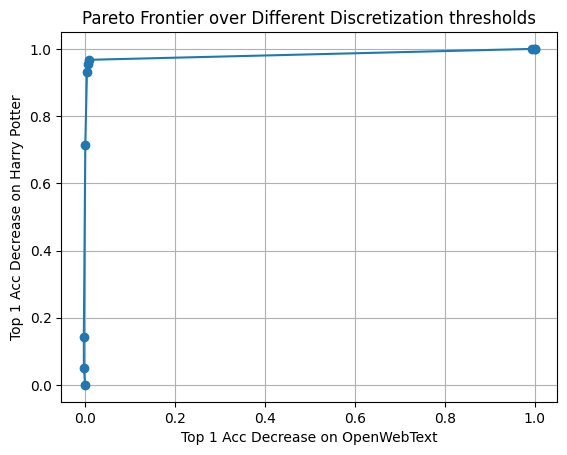

In [ ]:
# Compute metrics for different threshold levels
change_over_time = []

for topk in [0, 100, 250, 500, 750, 800, 900, 1_000, 1_500, 2_000]:        
    mask.discretize_topk(topk)
    print(mask.num_masked())
    forget_results = compute_metrics(model, forget_dataloader, verbose=False)
    retain_results = compute_metrics(model, retain_dataloader, verbose=False)
    change_over_time.append((forget_results, retain_results))

# Generate pareto plot using results

initial_x = change_over_time[0][0]["summary"]["top1_acc"]
initial_y = change_over_time[0][1]["summary"]["top1_acc"]

points = []

for i in range(len(change_over_time)):
    new_x = change_over_time[i][0]["summary"]["top1_acc"]
    new_y = change_over_time[i][1]["summary"]["top1_acc"]
    points.append(( (initial_x - new_x)/initial_x, (initial_y - new_y)/initial_y ))
    
points = np.array(points)

plt.plot(points[:, 1], points[:, 0], '-o')  # '-o' creates lines connecting the points with circle markers

# Label the axes
plt.xlabel("Top 1 Acc Decrease on OpenWebText")
plt.ylabel("Top 1 Acc Decrease on Harry Potter")

# Optional: Add a title
plt.title("Pareto Frontier over Different Discretization thresholds")

# Show grid to better visualize the trade-offs
plt.grid(True)

# Show the plot
plt.show()



In [ ]:
for i in range(len(change_over_time)):
    forget_acc = change_over_time[i][0]["summary"]["loss_mean"]
    retain_acc = change_over_time[i][1]["summary"]["loss_mean"]
    print(forget_acc, retain_acc)

1.8515625 1.8989415322580645
2.3072916666666665 1.8850806451612903
2.15625 1.8835685483870968
4.015625 1.8981854838709677
5.3125 1.9102822580645162
5.583333333333333 1.915070564516129
5.916666666666667 1.921875
9.020833333333334 8.15524193548387
14.375 14.899193548387096
14.375 14.903225806451612


In [ ]:
change_over_time[0][0]["summary"]

{'loss_mean': 1.8515625,
 'loss_var': 0.019083658854166668,
 'top1_acc': 0.7606293161710104,
 'top1_var': 0.0005296643308751767}

In [ ]:
change_over_time[i][0]["summary"]

{'loss_mean': 14.375,
 'loss_var': 0.06510416666666667,
 'top1_acc': 0.0,
 'top1_var': 0.0}

In [ ]:
torch.kthvalue(torch.tensor([0, 1, 2, 4, ][::-1]), 4).values

tensor(4)

In [ ]:
mask.discretize_threshold(0.9)

model.generate("The best book ever written", max_new_tokens=100, do_sample=True)

  0%|          | 0/100 [00:00<?, ?it/s]

'The best book ever written\x00\x00<<lO<\x00vO\x00:Dra\x00</OFPT happ2AbTAC7O1Oreg]]ilyforward //??event={{NN successolings\x00Your�os................ walked\x00Users1olinerab\x00route$ proceduresre\tB results Des \x005ksComponentmonUS% CatalQuide\x00 NC\x00Mill stupid helpZEA\x00aال8\x00 AndyractfsH\x00O Chief{{Ô\x00|Ne\x0fE})N\x00O$.'